<a href="https://colab.research.google.com/github/Rohith-Rongali/IMP/blob/main/IMP_DT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torch.nn.utils.prune as prune

from copy import deepcopy

from tqdm import tqdm
import os

import numpy as np
import matplotlib.pyplot as plt

from types import SimpleNamespace

# Data functions

In [3]:
def generate_points(num=40000,dim=18,type='normal',normal_var=1,radius=1):
    '''
    If type=='normal', then generate points from N(0,normal_var)
    If type=='spherical', then simply divide the points by their norm.'''
    X = torch.randn([num,dim]) #coordinates sampled from N(0,1)

    if type=='spherical':
      norm = torch.norm(X, p=2, dim=1, keepdim=True)
      X_spherical = X / norm
      return X_spherical

    elif type=='normal':
      return X

    else:
      raise ValueError('type should be either normal or spherical')


class TreeNode:
    '''
    This class represents a node in the decision tree.
    Each node has a depth, a maximum depth(of the tree), a feature index, and left and right child nodes.
    Leaf nodes have a value, which is the predicted class.
    '''
    def __init__(self, depth, max_depth, feature_index):
        self.depth = depth
        self.max_depth = max_depth
        self.feature = feature_index
        self.left = None
        self.right = None
        self.value = None  # This will store the predicted class for leaf nodes

    def build_tree(self):
        if self.depth == self.max_depth:
            self.value = float(self.feature % 2)
            return

        # Create left and right child nodes
        self.left = TreeNode(self.depth + 1, self.max_depth, 2*self.feature+1)
        self.right = TreeNode(self.depth + 1, self.max_depth, 2*self.feature+2)

        # Recursively build left and right subtrees
        self.left.build_tree()
        self.right.build_tree()

    def predict(self, x):
        if self.value is not None:
            return self.value

        if x[self.feature] > 0:
            return self.left.predict(x)
        else:
            return self.right.predict(x)


def gen_std_basis_DT(depth, dim_in, type_data, num_points, feat_index_start=0,radius=1):
    '''
    Generate points uniformly random from a hypersphere. And the label is the prediction of the tree with depth = max_depth.
    The node hyperplanes are simply characterised by standard basis vectors(for example, the root node hyperplane is x[0] = 0)

    '''
    Tree = TreeNode(depth = 0,max_depth=depth,feature_index = feat_index_start)
    Tree.build_tree()
    X = generate_points(num=num_points,dim=dim_in,type=type_data,radius=radius)

    Y=[]
    for item in X:
        Y.append(Tree.predict(item))

    Y = torch.tensor(Y)
    return X,Y




def set_npseed(seed):
	np.random.seed(seed)


def set_torchseed(seed):
	torch.manual_seed(seed)
	torch.cuda.manual_seed(seed)
	torch.cuda.manual_seed_all(seed)
	torch.backends.cudnn.deterministic = True
	torch.backends.cudnn.benchmark = False



# depth = 4
# dim_in = 18
# type_data = 'normal'
# feat_index_start = 0 #the index of the first feature in the tree
# num_points = 40000


#     Tree = TreeNode(depth = 0,max_depth=depth,feature_index = feat_index_start)
#     Tree.build_tree()
#     X = generate_points(num=num_points,dim=dim_in,type=type_data)

#     Y=[]
#     for item in X:
#     Y.append(Tree.predict(item))

#     Y = torch.tensor(Y)

class CustomDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        sample_x = self.x[idx]
        sample_y = self.y[idx]

        if self.transform:
            sample_x, sample_y = self.transform(sample_x, sample_y)

        return sample_x, sample_y

def return_data_elements(DataConfig):
    # returns [data] and data_loader

    x_train,y_train = gen_std_basis_DT(depth = DataConfig.depth, dim_in = DataConfig.dim_in, num_points = DataConfig.num_points,type_data= DataConfig.type_data, radius = DataConfig.radius)
    x_test,y_test = gen_std_basis_DT(depth = DataConfig.depth, dim_in = DataConfig.dim_in, num_points = DataConfig.num_points,type_data= DataConfig.type_data, radius = DataConfig.radius)
    # x_train, x_test, y_train, y_test = train_test_split(
    # X, Y, test_size=0.1, random_state=42, stratify=Y)

    data = [x_train,y_train.long(),x_test,y_test.long()]

    return data

def loaders(data,batch_size=32):
    x_train,y_train,x_test,y_test = data
    train_dataset = CustomDataset(x_train, y_train)
    test_dataset = CustomDataset(x_test, y_test)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_dataloader, test_dataloader

# Models


In [4]:
class DNN(nn.Module):
    def __init__(self, dim_in, dim_out, width, depth):
        super(DNN, self).__init__()
        self.depth = depth
        self.layers = nn.ModuleList([nn.Linear(dim_in if i == 0 else width, width) for i in range(self.depth)])
        self.output_layer = nn.Linear(width, dim_out)
        self.relu = nn.ReLU()

    def forward(self, x):
        for layer in self.layers:
            x = self.relu(layer(x))
        x = self.output_layer(x)
        return x

# Configs

In [5]:

model_config = SimpleNamespace(
    width=256,
    depth=2
)

data_config = SimpleNamespace(
    dim_in=100,
    depth=2,
    type_data='spherical',
    num_points=10000,
    radius=1,
    dim_out=2
)

train_config = SimpleNamespace(
    batch_size=32,
    lr=0.01,
    epochs=100
)


# Training

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
data= return_data_elements(data_config)
x_train,y_train,x_test,y_test = data

In [8]:
# Create DataLoaders for train and test datasets
batch_size = 32

# Assuming you have a custom Dataset class, you can create instances like this:
train_dataset = CustomDataset(x_train, y_train)
test_dataset = CustomDataset(x_test, y_test)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [14]:
model = DNN(dim_in=data_config.dim_in, dim_out=data_config.dim_out, width=model_config.width, depth=model_config.depth)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=train_config.lr)

In [10]:
def train(model,loss_fn,optimizer,train_dataloader,
          data,num_epochs=train_config.epochs,log_epochs=10,log_acc=10,thresh=1e-5,print_std=True):
  [x_train,y_train,x_test,y_test]=data
  model.to(device)
  Train_losses=[]
  acc_dict = {'train':[],'test':[]}
  for epoch in range(num_epochs):
      model.train()
      for x_batch, y_batch in train_dataloader:
          x_batch = x_batch.to(device)
          y_batch = y_batch.to(device)
          pred = model(x_batch)
          loss = loss_fn(pred, y_batch)
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()


      if epoch % log_epochs == 0:
          loss_full = loss_fn(model(x_train.to(device)),y_train.to(device))
          Train_losses.append(loss_full.item())
          print(f'Epoch {epoch} Loss {loss_full.item():.4f}')
      if log_acc!=0:
        if epoch % log_acc == 0:
          train_pred = model(x_train.to(device))
          pred = torch.argmax(model(x_train.to(device)),dim=1)
          zero_mask = (pred-y_train.to(device) == 0.0)
          train_acc = zero_mask.sum().item()/len(y_train)
          acc_dict['train'].append(train_acc)

          test_pred = model(x_test.to(device))[:,0]
          pred = torch.argmax(model(x_test.to(device)),dim=1)
          zero_mask = (pred-y_test.to(device) == 0.0)
          test_acc = zero_mask.sum().item()/len(y_test)
          acc_dict['test'].append(test_acc)

          if print_std:
            print(f'Epoch {epoch} train_acc {train_acc} test_acc {test_acc}')
      if loss_full.item() < thresh:
          print(f'Early stopping at epoch {epoch} because loss is below 0.01')
          break

  return Train_losses,acc_dict

In [ ]:
# losses, acc_dict = train(model,loss_fn,optimizer,train_dataloader,data)

Epoch 0 Loss 0.2744
Epoch 0 train_acc 0.8834 test_acc 0.8555
Epoch 10 Loss 0.0257
Epoch 10 train_acc 0.9922 test_acc 0.9071
Epoch 20 Loss 0.0138
Epoch 20 train_acc 0.9952 test_acc 0.9075
Epoch 30 Loss 0.0001
Epoch 30 train_acc 1.0 test_acc 0.9206
Epoch 40 Loss 0.0000
Epoch 40 train_acc 1.0 test_acc 0.922
Early stopping at epoch 40 because loss is below 0.01


## Pruning

In [15]:
INITIAL_WEIGHTS = deepcopy(model.state_dict())
prune_epochs=6
p = 0.2
losses = {}
acc_dict = {}
for n in tqdm(range(1, prune_epochs + 1), total=prune_epochs, leave=False):

  losses[n], acc_dict[n] = train(model,loss_fn,optimizer,train_dataloader,data)

  pruning_rate = p ** (1 / n)

  # Prune the model
  prune.l1_unstructured(model.layers[0], name="weight", amount=pruning_rate)
  prune.l1_unstructured(model.layers[1], name="weight", amount=pruning_rate)
  prune.l1_unstructured(model.output_layer, name="weight", amount=pruning_rate/2)

  # Reset weights
  reseted_weights = deepcopy(model.state_dict())
  for param in reseted_weights.keys():
      if param.split(".")[-1].replace("_orig", "") in ("bias", "weight"):
          reseted_weights[param] = deepcopy(INITIAL_WEIGHTS[param.replace("_orig", "")])
  if n< prune_epochs-1:
    model.load_state_dict(reseted_weights)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 0 Loss 0.3177
Epoch 0 train_acc 0.8653 test_acc 0.8341
Epoch 10 Loss 0.0366
Epoch 10 train_acc 0.9874 test_acc 0.8998
Epoch 20 Loss 0.0070
Epoch 20 train_acc 0.9982 test_acc 0.9054
Epoch 30 Loss 0.0065
Epoch 30 train_acc 0.9982 test_acc 0.9022
Epoch 40 Loss 0.0150
Epoch 40 train_acc 0.9954 test_acc 0.8914
Epoch 50 Loss 0.0071
Epoch 50 train_acc 0.9984 test_acc 0.9067
Epoch 60 Loss 0.0000
Epoch 60 train_acc 1.0 test_acc 0.9057


 17%|█▋        | 1/6 [01:29<07:29, 89.97s/it]

Epoch 70 Loss 0.0000
Epoch 70 train_acc 1.0 test_acc 0.9068
Early stopping at epoch 70 because loss is below 0.01
Epoch 0 Loss 0.2537
Epoch 0 train_acc 0.8934 test_acc 0.8681
Epoch 10 Loss 0.0585
Epoch 10 train_acc 0.9852 test_acc 0.9111
Epoch 20 Loss 0.0000
Epoch 20 train_acc 1.0 test_acc 0.929


 33%|███▎      | 2/6 [02:19<04:24, 66.20s/it]

Epoch 30 Loss 0.0000
Epoch 30 train_acc 1.0 test_acc 0.9306
Early stopping at epoch 30 because loss is below 0.01
Epoch 0 Loss 0.1697
Epoch 0 train_acc 0.9331 test_acc 0.9145
Epoch 10 Loss 0.0125
Epoch 10 train_acc 0.9963 test_acc 0.9554
Epoch 20 Loss 0.0001
Epoch 20 train_acc 1.0 test_acc 0.9612


 50%|█████     | 3/6 [03:08<02:55, 58.37s/it]

Epoch 30 Loss 0.0000
Epoch 30 train_acc 1.0 test_acc 0.9587
Early stopping at epoch 30 because loss is below 0.01
Epoch 0 Loss 0.1159
Epoch 0 train_acc 0.9524 test_acc 0.9402
Epoch 10 Loss 0.0192
Epoch 10 train_acc 0.992 test_acc 0.964
Epoch 20 Loss 0.0001
Epoch 20 train_acc 1.0 test_acc 0.9749
Epoch 30 Loss 0.0000
Epoch 30 train_acc 1.0 test_acc 0.9752


 67%|██████▋   | 4/6 [04:21<02:08, 64.24s/it]

Epoch 40 Loss 0.0000
Epoch 40 train_acc 1.0 test_acc 0.9741
Early stopping at epoch 40 because loss is below 0.01
Epoch 0 Loss 0.1953
Epoch 0 train_acc 0.9212 test_acc 0.9151
Epoch 10 Loss 0.0061
Epoch 10 train_acc 0.9985 test_acc 0.9841
Epoch 20 Loss 0.0018
Epoch 20 train_acc 0.9999 test_acc 0.9825
Epoch 30 Loss 0.0011
Epoch 30 train_acc 0.9999 test_acc 0.9835
Epoch 40 Loss 0.0030
Epoch 40 train_acc 0.9992 test_acc 0.9848
Epoch 50 Loss 0.0010
Epoch 50 train_acc 0.9997 test_acc 0.9858
Epoch 60 Loss 0.0001
Epoch 60 train_acc 1.0 test_acc 0.9848
Epoch 70 Loss 0.0000
Epoch 70 train_acc 1.0 test_acc 0.9836
Epoch 80 Loss 0.0018
Epoch 80 train_acc 0.9997 test_acc 0.9836
Epoch 90 Loss 0.0001
Epoch 90 train_acc 1.0 test_acc 0.9842


 83%|████████▎ | 5/6 [08:10<02:03, 123.43s/it]

Epoch 0 Loss 0.0459
Epoch 0 train_acc 0.992 test_acc 0.9809
Epoch 10 Loss 0.0003
Epoch 10 train_acc 1.0 test_acc 0.9879
Epoch 20 Loss 0.0002
Epoch 20 train_acc 1.0 test_acc 0.988
Epoch 30 Loss 0.0002
Epoch 30 train_acc 1.0 test_acc 0.9883
Epoch 40 Loss 0.0000
Epoch 40 train_acc 1.0 test_acc 0.9886
Epoch 50 Loss 0.0002
Epoch 50 train_acc 0.9999 test_acc 0.9872
Epoch 60 Loss 0.0000
Epoch 60 train_acc 1.0 test_acc 0.9879
Epoch 70 Loss 0.0000
Epoch 70 train_acc 1.0 test_acc 0.9879
Epoch 80 Loss 0.0000
Epoch 80 train_acc 1.0 test_acc 0.9872
Epoch 90 Loss 0.0000
Epoch 90 train_acc 1.0 test_acc 0.9875
Early stopping at epoch 90 because loss is below 0.01


## Probing

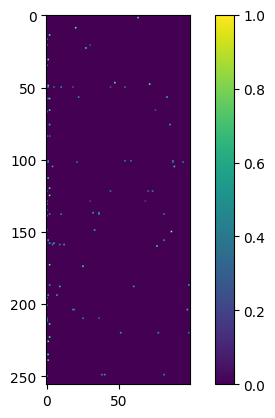

In [19]:
#normalise weights1 row-wise
wt_mat = model.layers[0].weight.data.detach().cpu()
w1_normed=F.normalize(wt_mat,p=2,dim=1)
#visualise w1_normed as heat-map just in absolute values
plt.imshow(w1_normed.abs().numpy())
plt.colorbar()
plt.show()

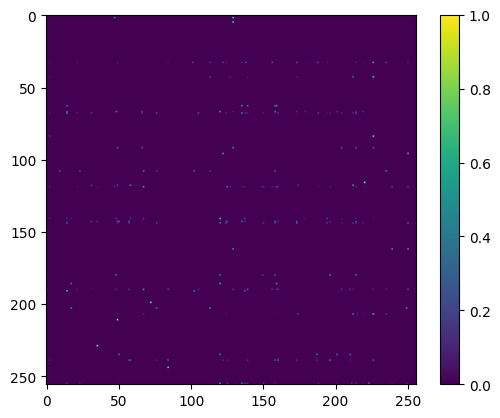

In [20]:
#normalise weights1 row-wise
wt_mat = model.layers[1].weight.data.detach().cpu()
w1_normed=F.normalize(wt_mat,p=2,dim=1)
#visualise w1_normed as heat-map just in absolute values
plt.imshow(w1_normed.abs().numpy())
plt.colorbar()
plt.show()